# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# Basic RNNs

# Manual RNN

In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.71978897 -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200275 -0.9999998 ]
 [-0.12210423  0.6280527   0.9671843  -0.9937122  -0.25839362]
 [ 0.9999983  -0.9999994  -0.9999975  -0.8594331  -0.9999881 ]
 [ 0.99928284 -0.99999803 -0.9999058   0.9857963  -0.92205757]]


# Using static_rnn()

Note: tf.contrib.rnn was partially moved to the core API in TensorFlow 1.2. Most of the *Cell and *Wrapper classes are now available in tf.nn.rnn_cell, and the tf.contrib.rnn.static_rnn() function is available as tf.nn.static_rnn().

In [7]:
n_inputs = 3
n_neurons = 5

In [8]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, [X0, X1],
                                       dtype=tf.float32)
Y0, Y1 = output_seqs

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542541 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.99976057, -0.06679279, -0.9999803 ,  0.99982214],
       [-0.65249425, -0.51520866, -0.37968954, -0.5922594 , -0.08968391],
       [ 0.998624  , -0.99715203, -0.03308626, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307606 ,  0.79671973]],
      dtype=float32)

In [13]:
from tensorflow_graph_in_jupyter import show_graph

In [14]:
show_graph(tf.get_default_graph())

# Packing sequences

In [15]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, X_seqs,
                                       dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [19]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999999 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971031  -0.9964609 ]
  [-0.637116    0.11300932  0.5798437   0.43105596 -0.63716984]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987185 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191977  0.7827872   0.9525682  -0.9781773 ]]]


In [20]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999999 ]
 [-0.637116    0.11300932  0.5798437   0.43105596 -0.63716984]
 [-0.9165386  -0.9945604   0.896054    0.99987185 -0.9999751 ]
 [-0.02746338 -0.73191977  0.7827872   0.9525682  -0.9781773 ]]


# Using dynamic_rnn()

In [21]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [22]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [23]:
init = tf.global_variables_initializer()

In [24]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [25]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.9999959   0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.8522789   0.5845349  -0.7878095 ]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.9999999  -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.36009568  0.7624866   0.99817705  0.80142003]]]


In [26]:
show_graph(tf.get_default_graph())

# Setting the sequence lengths

In [27]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

In [28]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:
init = tf.global_variables_initializer()

In [30]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [31]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [32]:
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.9567258   0.9983168   0.99970174  0.9651857 ]]

 [[-0.9998612   0.6702291   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.96135855  0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [33]:
print(states_val)

[[-1.          0.9567258   0.9983168   0.99970174  0.9651857 ]
 [-0.9998612   0.6702291   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]
 [-0.96135855  0.9568762   0.7132288   0.97729224 -0.0958299 ]]


# Training a sequence classifier

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.

In [34]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.


In [35]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [36]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [37]:
X_test = X_test.reshape((-1, n_steps, n_inputs))

In [38]:
n_epochs = 20
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.9533333 Test accuracy: 0.9288
1 Last batch accuracy: 0.96 Test accuracy: 0.9471
2 Last batch accuracy: 0.96 Test accuracy: 0.9495
3 Last batch accuracy: 0.96666664 Test accuracy: 0.9557
4 Last batch accuracy: 0.9866667 Test accuracy: 0.9641
5 Last batch accuracy: 0.94 Test accuracy: 0.9673
6 Last batch accuracy: 0.97333336 Test accuracy: 0.9691
7 Last batch accuracy: 0.96 Test accuracy: 0.972
8 Last batch accuracy: 0.9866667 Test accuracy: 0.9698
9 Last batch accuracy: 0.98 Test accuracy: 0.9711
10 Last batch accuracy: 0.9866667 Test accuracy: 0.973
11 Last batch accuracy: 0.99333334 Test accuracy: 0.9749
12 Last batch accuracy: 0.97333336 Test accuracy: 0.9679
13 Last batch accuracy: 0.97333336 Test accuracy: 0.9717
14 Last batch accuracy: 0.9866667 Test accuracy: 0.9757
15 Last batch accuracy: 0.97333336 Test accuracy: 0.9754
16 Last batch accuracy: 0.99333334 Test accuracy: 0.981
17 Last batch accuracy: 0.9866667 Test accuracy: 0.9728
18 Last batch accuracy:

# Multi-layer RNN

In [39]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [40]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [41]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [42]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.94666666 Test accuracy: 0.9418
1 Last batch accuracy: 0.94 Test accuracy: 0.9548
2 Last batch accuracy: 0.96 Test accuracy: 0.9709
3 Last batch accuracy: 0.99333334 Test accuracy: 0.9712
4 Last batch accuracy: 0.98 Test accuracy: 0.9636
5 Last batch accuracy: 0.96666664 Test accuracy: 0.9791
6 Last batch accuracy: 1.0 Test accuracy: 0.9807
7 Last batch accuracy: 0.9866667 Test accuracy: 0.9779
8 Last batch accuracy: 1.0 Test accuracy: 0.9769
9 Last batch accuracy: 0.98 Test accuracy: 0.9796


# Time series

In [43]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


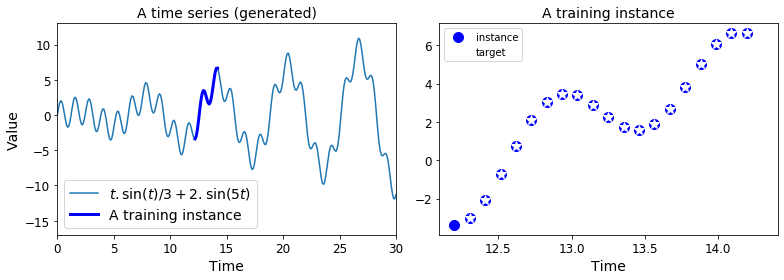

In [44]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [45]:
X_batch, y_batch = next_batch(1, n_steps)

In [46]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

# Using an OuputProjectionWrapper

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each training instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a single value:

In [47]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [48]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [49]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [50]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [51]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [52]:
saver = tf.train.Saver()

In [53]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./tf_logs/TimeSeries/my_time_series_model") 

0 	MSE: 11.967254
100 	MSE: 0.5228202
200 	MSE: 0.14977808
300 	MSE: 0.07325034
400 	MSE: 0.061879266
500 	MSE: 0.05927128
600 	MSE: 0.053488694
700 	MSE: 0.047909364
800 	MSE: 0.05056545
900 	MSE: 0.047495846
1000 	MSE: 0.047221784
1100 	MSE: 0.0478956
1200 	MSE: 0.04164593
1300 	MSE: 0.047553346
1400 	MSE: 0.042062722


In [54]:
with tf.Session() as sess:                         
    saver.restore(sess, "./tf_logs/TimeSeries/my_time_series_model")   

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tf_logs/TimeSeries/my_time_series_model


In [55]:
y_pred

array([[[-3.4075022 ],
        [-2.45405   ],
        [-1.1529151 ],
        [ 0.75634277],
        [ 2.206273  ],
        [ 3.0817113 ],
        [ 3.4048316 ],
        [ 3.3657305 ],
        [ 2.8714778 ],
        [ 2.2016277 ],
        [ 1.6385707 ],
        [ 1.5041714 ],
        [ 1.8824657 ],
        [ 2.6810753 ],
        [ 3.8383503 ],
        [ 5.1122317 ],
        [ 6.1182013 ],
        [ 6.638973  ],
        [ 6.6334696 ],
        [ 6.103851  ]]], dtype=float32)

Saving figure time_series_pred_plot


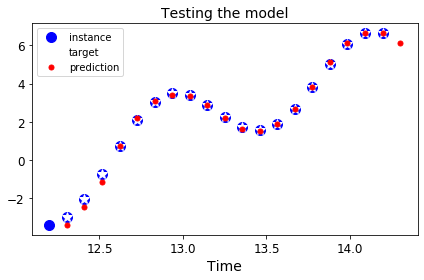

In [56]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

# Without using an OutputProjectionWrapper

In [57]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [58]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [59]:
n_outputs = 1
learning_rate = 0.001

In [60]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [61]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [62]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./tf_logs/TimeSeries/my_time_series_model")

0 	MSE: 13.907029
100 	MSE: 0.50587696
200 	MSE: 0.197302
300 	MSE: 0.10076102
400 	MSE: 0.06716492
500 	MSE: 0.06266778
600 	MSE: 0.057395738
700 	MSE: 0.05077005
800 	MSE: 0.05081276
900 	MSE: 0.04984224
1000 	MSE: 0.04876203
1100 	MSE: 0.050357707
1200 	MSE: 0.042572036
1300 	MSE: 0.050644875
1400 	MSE: 0.044234946


In [63]:
y_pred

array([[[-3.4317636],
        [-2.468046 ],
        [-1.1158276],
        [ 0.7572695],
        [ 2.1570258],
        [ 3.0666633],
        [ 3.4816227],
        [ 3.3987925],
        [ 2.8602989],
        [ 2.1884415],
        [ 1.6747154],
        [ 1.5760565],
        [ 1.9374434],
        [ 2.7674239],
        [ 3.8767912],
        [ 5.0783777],
        [ 6.0598307],
        [ 6.6321526],
        [ 6.6441836],
        [ 6.0413923]]], dtype=float32)

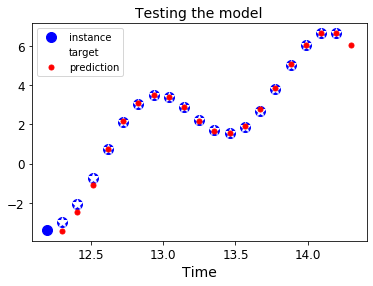

In [64]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

# Generating a creative new sequence

In [65]:
with tf.Session() as sess:                        
    saver.restore(sess, "./tf_logs/TimeSeries/my_time_series_model") 

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./tf_logs/TimeSeries/my_time_series_model


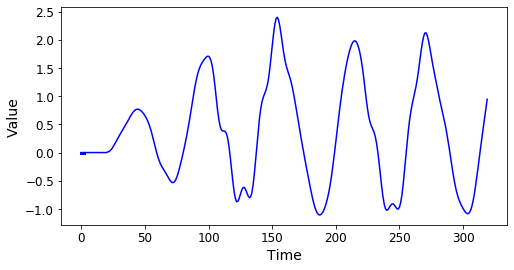

In [66]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./tf_logs/TimeSeries/my_time_series_model
Saving figure creative_sequence_plot


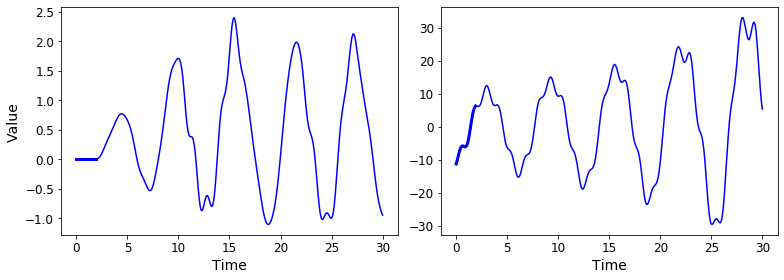

In [67]:
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/TimeSeries/my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

## MultiRNNCell

In [68]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [69]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [70]:
init = tf.global_variables_initializer()

In [71]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [72]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [73]:
outputs_val.shape

(2, 5, 100)

# Distributing a Deep RNN Across Multiple GPUs

Do NOT do this:

In [74]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

Instead, you need a DeviceCellWrapper:

In [75]:
import tensorflow as tf

class DeviceCellWrapper(tf.nn.rnn_cell.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [76]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [77]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Alternatively, since TensorFlow 1.1, you can use the tf.contrib.rnn.DeviceWrapper class (alias tf.nn.rnn_cell.DeviceWrapper since TF 1.2).

In [78]:
init = tf.global_variables_initializer()

In [79]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[-3.29020210e-02  1.17019251e-01 -4.58992757e-02 ...  3.84477004e-02
   -5.24900258e-02  5.80436923e-02]
  [ 3.54287811e-02 -7.42611289e-02 -6.42375052e-02 ... -2.45756999e-01
   -1.77626774e-01 -3.26534663e-03]
  [ 2.59726375e-01  1.44605204e-01  3.29312056e-01 ...  3.38822246e-01
    5.98853230e-02 -8.31450820e-02]
  ...
  [ 1.18043795e-01 -2.41663828e-01 -8.27798188e-01 ... -1.85782209e-01
    1.89682409e-01 -1.35261893e-01]
  [ 2.87830859e-01  3.92953753e-01 -3.15236926e-01 ... -7.85608962e-02
    4.32724684e-01 -6.61828965e-02]
  [ 7.49779940e-01  6.11053288e-01 -3.01685303e-01 ...  1.95649996e-01
   -1.62457019e-01 -5.23966178e-02]]

 [[-6.68028072e-02  7.35576749e-02 -2.90275272e-02 ... -7.79968202e-02
   -3.65773365e-02 -4.66752052e-02]
  [ 1.71546459e-01  4.28415416e-03  2.18818709e-03 ...  3.68537977e-02
   -8.13241750e-02  9.01001841e-02]
  [ 3.45635377e-02 -9.57523733e-02  1.59450263e-01 ...  1.63022071e-01
   -6.83044270e-02  1.07990310e-01]
  ...
  [ 1.96414426e-01 -2.1

# Dropout

In [80]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [81]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

Note: the input_keep_prob parameter can be a placeholder, making it possible to set it to any value you want during training, and to 1.0 during testing (effectively turning dropout off). This is a much more elegant solution than what was recommended in earlier versions of the book (i.e., writing your own wrapper class or having a separate model for training and testing). Thanks to Shen Cheng for bringing this to my attention.

In [82]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [83]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [84]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   
            print(iteration, "Training MSE:", mse) 
    
    saver.save(sess, "./tf_logs/RNNDropout/my_dropout_time_series_model")

0 Training MSE: 14.722076
100 Training MSE: 4.623025
200 Training MSE: 4.1317387
300 Training MSE: 4.115025
400 Training MSE: 3.4473546
500 Training MSE: 3.63058
600 Training MSE: 3.0821595
700 Training MSE: 3.638986
800 Training MSE: 4.4259415
900 Training MSE: 3.4719052
1000 Training MSE: 3.7725167
1100 Training MSE: 3.6786451
1200 Training MSE: 2.8897896
1300 Training MSE: 3.5690825
1400 Training MSE: 3.7513592


In [85]:
with tf.Session() as sess:
    saver.restore(sess, "./tf_logs/RNNDropout/my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./tf_logs/RNNDropout/my_dropout_time_series_model


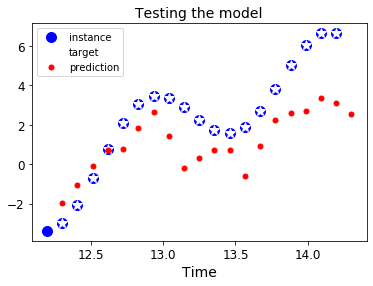

In [86]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Oops, it seems that Dropout does not help at all in this particular case. :/

# LSTM

In [87]:
reset_graph()

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [88]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [89]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [90]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [91]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.96666664 Test accuracy: 0.9562
1 Last batch accuracy: 0.96666664 Test accuracy: 0.9705
2 Last batch accuracy: 0.96 Test accuracy: 0.9668
3 Last batch accuracy: 0.99333334 Test accuracy: 0.9809
4 Last batch accuracy: 0.9866667 Test accuracy: 0.9839
5 Last batch accuracy: 0.98 Test accuracy: 0.9791
6 Last batch accuracy: 0.99333334 Test accuracy: 0.9884
7 Last batch accuracy: 0.9866667 Test accuracy: 0.9855
8 Last batch accuracy: 1.0 Test accuracy: 0.9884
9 Last batch accuracy: 0.99333334 Test accuracy: 0.9879


In [92]:
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, use_peepholes=True)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [93]:
gru_cell = tf.nn.rnn_cell.GRUCell(num_units=n_neurons)

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.


# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

## Fetch the data

In [94]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    os.makedirs(path, exist_ok=True)


def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [95]:
words = fetch_words_data()

In [96]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [97]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [98]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [99]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [100]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [101]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [102]:
np.random.seed(42)

In [103]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [104]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [105]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

## Build the model

In [106]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [107]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [108]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [109]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [110]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

## Train the model

In [111]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  289.90948486328125
Nearest to over: tt, tuned, manichaeans, fractional, cambridge, balaguer, fluoride, strenuously,
Nearest to one: imagines, tijuana, hindrance, motorcyclist, steadfastly, lords, letting, hutchinson,
Nearest to were: bezier, antibodies, nicknamed, panthers, compiler, tao, smarter, busy,
Nearest to may: failure, rna, efficacious, aspirin, lecompton, definitive, geese, amphibious,
Nearest to two: annihilate, bettors, wir, cindy, epinephrine, team, voluntarily, crystallize,
Nearest to its: knob, abeokuta, bracelet, bastards, ivens, objectivity, blanton, cold,
Nearest to than: lame, watts, stones, sram, elves, zarqawi, applets, cloves,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to they: lowly, deportation, shrewd, reznor, tojo, decadent, occured, risotto,
Nearest to is: interests, golfers, dropouts, egyptians, richards, legionnaires, opener, leonel,
Nearest to up: clair, drives, steadfas

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [114]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [115]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

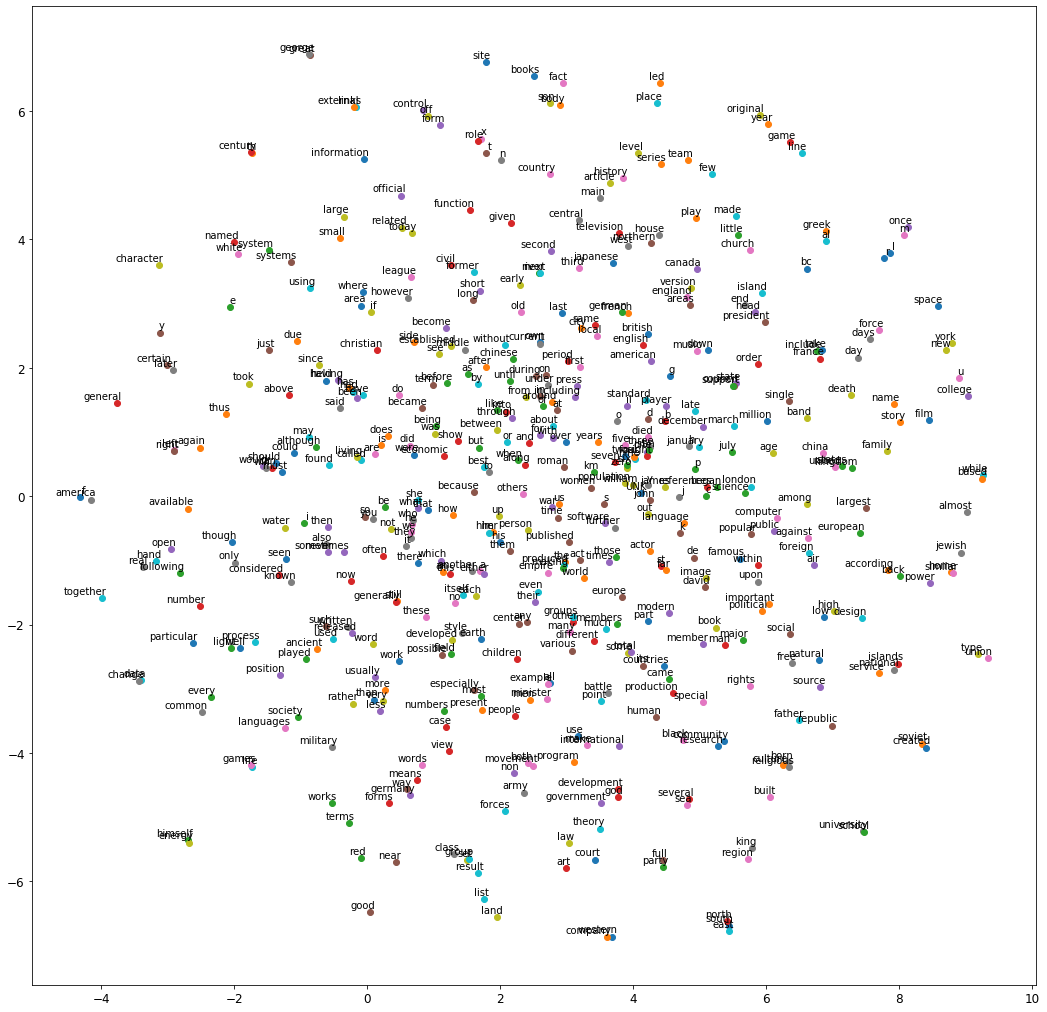

In [116]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Machine Translation

The `basic_rnn_seq2seq()` function creates a simple Encoder/Decoder model: it first runs an RNN to encode `encoder_inputs` into a state vector, then runs a decoder initialized with the last encoder state on `decoder_inputs`. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [117]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [118]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()